# THIẾT LẬP MÔI TRƯỜNG

In [20]:
import os
import numpy as np
import json
import re
import pandas as pd
import shutil
import unicodedata
from tqdm import tqdm
from PIL import Image, ExifTags, ImageDraw
from concurrent.futures import ThreadPoolExecutor, as_completed
from collections import Counter
from sklearn.model_selection import train_test_split
import ast

# Kết nối Google Drive

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


# Đường dẫn thư mục toàn cục

In [3]:
ROOT = ".."
DATA_PATH = os.path.join(ROOT, "data")
VIETOCR_DATASET = os.path.join(DATA_PATH, "VIETOCR")
IIIT5K_DATASET = os.path.join(DATA_PATH, "IIIT5K")
T5K_TRAIN_IMG = os.path.join(IIIT5K_DATASET, "train")
T5K_TEST_IMG = os.path.join(IIIT5K_DATASET, "test")
MODEL_PATH = os.path.join(ROOT, "model")
TEXT_PATH = os.path.join(MODEL_PATH, "text")

# Định nghĩa các hàm xử lý chuỗi

In [ ]:
def normalize_text(text):
    # Chuyển về dạng NFC (bình thường hóa unicode)
    text = unicodedata.normalize('NFC', text)
    # Chuyển về chữ thường
    text = text.lower()
    # Loại bỏ ký tự không phải chữ, số hoặc space
    # Giữ thêm các dấu câu cơ bản nếu cần (ở đây giữ a-z, 0-9 và space)
    text = re.sub(r"[^a-z0-9àáảãạăằắẳẵặâầấẩẫậèéẻẽẹêềếểễệìíỉĩịòóỏõọôồốổỗộơờớởỡợùúủũụưừứửữựỳýỷỹỵđ\s]", '', text)
    # Bỏ nhiều space liên tiếp
    text = re.sub(r'\s+', ' ', text).strip()
    return text


def tokenize(text):
    return list(text)


def build_vocab(list_of_token_lists, min_freq=1):
    counter = Counter()
    for tokens in list_of_token_lists:
        counter.update(tokens)

    chars = sorted([char for char, freq in counter.items() if freq >= min_freq])

    char2idx = {
        '<pad>': 0,
        '<sos>': 1,
        '<eos>': 2,
        '<unk>': 3
    }
    for idx, char in enumerate(chars, start=4):
        char2idx[char] = idx

    idx2char = {idx: char for char, idx in char2idx.items()}
    return char2idx, idx2char


def tokens_to_ids(tokens, vocab):
    ids = [vocab.get('<sos>')]
    ids += [vocab.get(char, vocab.get('<unk>')) for char in tokens]
    ids.append(vocab.get('<eos>'))
    return ids


def change_folder(text: str, raw: str, content: str):
    return text.replace(raw, content)

# Chuẩn hóa chuỗi

## Chuẩn hóa IIIT5K

In [70]:
train_data_file = os.path.join(IIIT5K_DATASET, "traindata.csv")
test_data_file = os.path.join(IIIT5K_DATASET, "testdata.csv")

def load_csv_file(file_path: str) -> pd.DataFrame:
    df = pd.read_csv(file_path)

    return df[["ImgName", "GroundTruth"]]


train_df = load_csv_file(train_data_file)
test_df = load_csv_file(test_data_file)

train_df['ImgName'] = train_df['ImgName'].apply(lambda x: change_folder(x, 'test', 'train'))
test_df['ImgName'] = test_df['ImgName'].apply(lambda x: change_folder(x, 'train', 'test'))

# Display some data to visualize
print('Train data')
display(train_df.head())

print('Testdata')
display(test_df.head())

Train data


,ImgName,GroundTruth
0,train/1002_1.png,PRIVATE
1,train/1002_2.png,PARKING
2,train/1009_1.png,SALUTES
3,train/100_1.png,DOLCE
4,train/100_2.png,GABBANA


Testdata


,ImgName,GroundTruth
0,test/1009_2.png,YOU
1,test/1017_1.png,RESCUE
2,test/1017_2.png,MISSION
3,test/1021_1.png,HOME
4,test/1023_1.png,BORDER


In [71]:
train_df['normalized'] = train_df['GroundTruth'].apply(normalize_text)
train_df['tokens'] = train_df['normalized'].apply(tokenize)
print("Train data")
display(train_df.head())

test_df['normalized'] = test_df['GroundTruth'].apply(normalize_text)
test_df['tokens'] = test_df['normalized'].apply(tokenize)
print("\nTest data")
display(test_df.head())

Train data


,ImgName,GroundTruth,normalized,tokens
0,train/1002_1.png,PRIVATE,private,"[p, r, i, v, a, t, e]"
1,train/1002_2.png,PARKING,parking,"[p, a, r, k, i, n, g]"
2,train/1009_1.png,SALUTES,salutes,"[s, a, l, u, t, e, s]"
3,train/100_1.png,DOLCE,dolce,"[d, o, l, c, e]"
4,train/100_2.png,GABBANA,gabbana,"[g, a, b, b, a, n, a]"



Test data


,ImgName,GroundTruth,normalized,tokens
0,test/1009_2.png,YOU,you,"[y, o, u]"
1,test/1017_1.png,RESCUE,rescue,"[r, e, s, c, u, e]"
2,test/1017_2.png,MISSION,mission,"[m, i, s, s, i, o, n]"
3,test/1021_1.png,HOME,home,"[h, o, m, e]"
4,test/1023_1.png,BORDER,border,"[b, o, r, d, e, r]"


## Chuẩn hóa VIETOCR

In [72]:
def load_vietocr_data(file_path: str):
    with open(file_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    df = pd.DataFrame(data)
    
    # Đổi tên cột cho đồng nhất
    df = df.rename(columns={
        'file_name': 'ImgName',
        'content': 'GroundTruth'
    })

    # # Chuẩn hóa và tokenize
    # df['normalized'] = df['GroundTruth'].apply(normalize_text)
    # df['tokens'] = df['normalized'].apply(tokenize)

    return df

label_file = os.path.join(VIETOCR_DATASET, "labels.json")
vietocr_data = load_vietocr_data(label_file)

print(f'Số lượng dữ liệu: {vietocr_data.count()}')
display(vietocr_data.head())

Số lượng dữ liệu: ImgName        5000
GroundTruth    5000
dtype: int64


,ImgName,GroundTruth
0,57765.jpg,Chèo sân đình là loại hình chèo cổ của những p...
1,50794.jpg,Cay gia pha
2,57893.jpg,"""chesterton thường được gọi là """"bậc thầy của ..."
3,21699.jpg,các mục tiêu khác không vào được bên trong
4,3794.jpg,ca Anh lan cac tinh o Vung Dat Thap (Flanders ...


In [73]:
vietocr_data['normalized'] = vietocr_data['GroundTruth'].apply(normalize_text)
vietocr_data['tokens'] = vietocr_data['normalized'].apply(tokenize)
vietocr_data.head()

,ImgName,GroundTruth,normalized,tokens
0,57765.jpg,Chèo sân đình là loại hình chèo cổ của những p...,chèo sân đình là loại hình chèo cổ của những p...,"[c, h, è, o, , s, â, n, , đ, ì, n, h, , l, ..."
1,50794.jpg,Cay gia pha,cay gia pha,"[c, a, y, , g, i, a, , p, h, a]"
2,57893.jpg,"""chesterton thường được gọi là """"bậc thầy của ...",chesterton thường được gọi là bậc thầy của ngh...,"[c, h, e, s, t, e, r, t, o, n, , t, h, ư, ờ, ..."
3,21699.jpg,các mục tiêu khác không vào được bên trong,các mục tiêu khác không vào được bên trong,"[c, á, c, , m, ụ, c, , t, i, ê, u, , k, h, ..."
4,3794.jpg,ca Anh lan cac tinh o Vung Dat Thap (Flanders ...,ca anh lan cac tinh o vung dat thap flanders v...,"[c, a, , a, n, h, , l, a, n, , c, a, c, , ..."


# Tạo từ điển (vocabulary)

In [74]:
t5k_tokens = train_df['tokens'].to_list() + test_df['tokens'].to_list()
vietocr_tokens = vietocr_data['tokens'].to_list()
all_tokens = t5k_tokens + vietocr_tokens
print(len(all_tokens))

10000


In [75]:
char2idx, idx2char = build_vocab(all_tokens, min_freq=1)
print(f'Số lượng từ vựng: {len(char2idx)}')
print(char2idx)

# Lưu vocab
vocab_path = os.path.join(TEXT_PATH, "vocab.json")
with open(vocab_path, "w", encoding="utf-8") as f:
    json.dump({'char2idx': char2idx, 'idx2char': idx2char}, f, ensure_ascii=False)

print(f"\nTừ vựng được lưu tại {vocab_path}")

Số lượng từ vựng: 108
{'<pad>': 0, '<sos>': 1, '<eos>': 2, '<unk>': 3, ' ': 4, '0': 5, '1': 6, '2': 7, '3': 8, '4': 9, '5': 10, '6': 11, '7': 12, '8': 13, '9': 14, 'a': 15, 'b': 16, 'c': 17, 'd': 18, 'e': 19, 'f': 20, 'g': 21, 'h': 22, 'i': 23, 'j': 24, 'k': 25, 'l': 26, 'm': 27, 'n': 28, 'o': 29, 'p': 30, 'q': 31, 'r': 32, 's': 33, 't': 34, 'u': 35, 'v': 36, 'w': 37, 'x': 38, 'y': 39, 'z': 40, 'à': 41, 'á': 42, 'â': 43, 'ã': 44, 'è': 45, 'é': 46, 'ê': 47, 'ì': 48, 'í': 49, 'ò': 50, 'ó': 51, 'ô': 52, 'õ': 53, 'ù': 54, 'ú': 55, 'ý': 56, 'ă': 57, 'đ': 58, 'ĩ': 59, 'ũ': 60, 'ơ': 61, 'ư': 62, 'ạ': 63, 'ả': 64, 'ấ': 65, 'ầ': 66, 'ẩ': 67, 'ẫ': 68, 'ậ': 69, 'ắ': 70, 'ằ': 71, 'ẳ': 72, 'ẵ': 73, 'ặ': 74, 'ẹ': 75, 'ẻ': 76, 'ẽ': 77, 'ế': 78, 'ề': 79, 'ể': 80, 'ễ': 81, 'ệ': 82, 'ỉ': 83, 'ị': 84, 'ọ': 85, 'ỏ': 86, 'ố': 87, 'ồ': 88, 'ổ': 89, 'ỗ': 90, 'ộ': 91, 'ớ': 92, 'ờ': 93, 'ở': 94, 'ỡ': 95, 'ợ': 96, 'ụ': 97, 'ủ': 98, 'ứ': 99, 'ừ': 100, 'ử': 101, 'ữ': 102, 'ự': 103, 'ỳ': 104, 'ỵ': 105, 'ỷ': 106, '

# Chuyển token về id

In [76]:
train_df['token_ids'] = train_df['tokens'].apply(lambda x: tokens_to_ids(x, char2idx))
test_df['token_ids'] = test_df['tokens'].apply(lambda x: tokens_to_ids(x, char2idx))
vietocr_data['token_ids'] = vietocr_data['tokens'].apply(lambda x: tokens_to_ids(x, char2idx))
display(train_df.head())
display(vietocr_data.head())

,ImgName,GroundTruth,normalized,tokens,token_ids
0,train/1002_1.png,PRIVATE,private,"[p, r, i, v, a, t, e]","[1, 30, 32, 23, 36, 15, 34, 19, 2]"
1,train/1002_2.png,PARKING,parking,"[p, a, r, k, i, n, g]","[1, 30, 15, 32, 25, 23, 28, 21, 2]"
2,train/1009_1.png,SALUTES,salutes,"[s, a, l, u, t, e, s]","[1, 33, 15, 26, 35, 34, 19, 33, 2]"
3,train/100_1.png,DOLCE,dolce,"[d, o, l, c, e]","[1, 18, 29, 26, 17, 19, 2]"
4,train/100_2.png,GABBANA,gabbana,"[g, a, b, b, a, n, a]","[1, 21, 15, 16, 16, 15, 28, 15, 2]"


,ImgName,GroundTruth,normalized,tokens,token_ids
0,57765.jpg,Chèo sân đình là loại hình chèo cổ của những p...,chèo sân đình là loại hình chèo cổ của những p...,"[c, h, è, o, , s, â, n, , đ, ì, n, h, , l, ...","[1, 17, 22, 45, 29, 4, 33, 43, 28, 4, 58, 48, ..."
1,50794.jpg,Cay gia pha,cay gia pha,"[c, a, y, , g, i, a, , p, h, a]","[1, 17, 15, 39, 4, 21, 23, 15, 4, 30, 22, 15, 2]"
2,57893.jpg,"""chesterton thường được gọi là """"bậc thầy của ...",chesterton thường được gọi là bậc thầy của ngh...,"[c, h, e, s, t, e, r, t, o, n, , t, h, ư, ờ, ...","[1, 17, 22, 19, 33, 34, 19, 32, 34, 29, 28, 4,..."
3,21699.jpg,các mục tiêu khác không vào được bên trong,các mục tiêu khác không vào được bên trong,"[c, á, c, , m, ụ, c, , t, i, ê, u, , k, h, ...","[1, 17, 42, 17, 4, 27, 97, 17, 4, 34, 23, 47, ..."
4,3794.jpg,ca Anh lan cac tinh o Vung Dat Thap (Flanders ...,ca anh lan cac tinh o vung dat thap flanders v...,"[c, a, , a, n, h, , l, a, n, , c, a, c, , ...","[1, 17, 15, 4, 15, 28, 22, 4, 26, 15, 28, 4, 1..."


In [77]:
def save_processed_data(save_path: str, data: pd.DataFrame):
    data.to_csv(save_path, index=False)
    print(f"Dữ liệu đã xử lý được lưu tại {save_path}")


# Lưu dữ liệu cho tập IIIT5K
t5k_processed_train = os.path.join(IIIT5K_DATASET, "traindata_processed.csv")
t5k_processed_test = os.path.join(IIIT5K_DATASET, "testdata_processed.csv")

save_processed_data(t5k_processed_train, train_df)
save_processed_data(t5k_processed_test, test_df)


# Lưu dữ liệu cho tập VIETOCR
vietocr_processed = os.path.join(VIETOCR_DATASET, "data_processed.csv")
save_processed_data(vietocr_processed, vietocr_data)

Dữ liệu đã xử lý được lưu tại ..\data\IIIT5K\traindata_processed.csv
Dữ liệu đã xử lý được lưu tại ..\data\IIIT5K\testdata_processed.csv
Dữ liệu đã xử lý được lưu tại ..\data\VIETOCR\data_processed.csv


# Chuyển data từ test sang train

In [ ]:
def load_csv_file(file_path: str) -> pd.DataFrame:
    df = pd.read_csv(file_path)

    return df


IIIT5K_DATASET = {
    'data_path': os.path.join(DATA_PATH, "IIIT5K"),
    'image_train': os.path.join(DATA_PATH, "IIIT5K", "train"),
    'image_test': os.path.join(DATA_PATH, "IIIT5K", "test"),
    'train_data': os.path.join(DATA_PATH, "IIIT5K", "traindata_processed.csv"),
    'test_data': os.path.join(DATA_PATH, "IIIT5K", "testdata_processed.csv"),
}


train_data = load_csv_file(IIIT5K_DATASET['train_data'])
test_data = load_csv_file(IIIT5K_DATASET['test_data'])

print(f"Số lượng dữ liệu train: {len(train_data)}")
print(f"Số lượng dữ liệu test: {len(test_data)}")


moved_data = test_data.iloc[:1000]
test_data = test_data.iloc[1000:].reset_index(drop=True)

# Di chuyển ảnh sang train
for img_file in moved_data['ImgName']:
    src_path = os.path.join(IIIT5K_DATASET['data_path'], img_file)
    dst_path = os.path.join(IIIT5K_DATASET['data_path'], img_file.replace('test', 'train'))
    if os.path.exists(src_path):
        shutil.move(src_path, dst_path)
    else:
        print(f"Không tìm thấy ảnh: {src_path}")

train_data = pd.concat([train_data, moved_data], ignore_index=True)
train_data['ImgName'] = train_data['ImgName'].apply(lambda x: change_folder(x, 'test', 'train'))

display(train_data.tail())

display(test_data.tail())
print(f"Số lượng dữ liệu train: {len(train_data)}")
print(f"Số lượng dữ liệu test: {len(test_data)}")

Số lượng dữ liệu train: 3000
Số lượng dữ liệu test: 2000


,ImgName,GroundTruth,normalized,tokens,token_ids
3995,train/5050_2.png,LEYENDA,leyenda,"['l', 'e', 'y', 'e', 'n', 'd', 'a']","[1, 26, 19, 39, 19, 28, 18, 15, 2]"
3996,train/5050_4.png,TIO,tio,"['t', 'i', 'o']","[1, 34, 23, 29, 2]"
3997,train/5050_5.png,BOONMEE,boonmee,"['b', 'o', 'o', 'n', 'm', 'e', 'e']","[1, 16, 29, 29, 28, 27, 19, 19, 2]"
3998,train/5051_11.png,WALK,walk,"['w', 'a', 'l', 'k']","[1, 37, 15, 26, 25, 2]"
3999,train/5051_12.png,THE,the,"['t', 'h', 'e']","[1, 34, 22, 19, 2]"


,ImgName,GroundTruth,normalized,tokens,token_ids
995,test/997_7.png,FOR,for,"['f', 'o', 'r']","[1, 20, 29, 32, 2]"
996,test/999_2.png,TO,to,"['t', 'o']","[1, 34, 29, 2]"
997,test/999_3.png,WRITE,write,"['w', 'r', 'i', 't', 'e']","[1, 37, 32, 23, 34, 19, 2]"
998,test/999_4.png,GREAT,great,"['g', 'r', 'e', 'a', 't']","[1, 21, 32, 19, 15, 34, 2]"
999,test/999_5.png,COPY,copy,"['c', 'o', 'p', 'y']","[1, 17, 29, 30, 39, 2]"


Số lượng dữ liệu train: 4000
Số lượng dữ liệu test: 1000


In [80]:
# Lưu dữ liệu cho tập IIIT5K
t5k_processed_train = os.path.join(IIIT5K_DATASET['data_path'], "traindata_processed.csv")
t5k_processed_test = os.path.join(IIIT5K_DATASET['data_path'], "testdata_processed.csv")

save_processed_data(t5k_processed_train, train_data)
save_processed_data(t5k_processed_test, test_data)

Dữ liệu đã xử lý được lưu tại ..\data\IIIT5K\traindata_processed.csv
Dữ liệu đã xử lý được lưu tại ..\data\IIIT5K\testdata_processed.csv


# Xử lý Vietnamese Dataset

## Định nghĩa đường dẫn

In [5]:
VIETNAMESE_PATH = os.path.join(DATA_PATH, "vietnamese")
VIETNAMESE_DATASET = {
    'labels': os.path.join(VIETNAMESE_PATH, 'labels'),
    'train_images': os.path.join(VIETNAMESE_PATH, 'train_images'),
    'test_images': os.path.join(VIETNAMESE_PATH, 'test_images'),
    'unseen_images': os.path.join(VIETNAMESE_PATH, 'unseen_test_images'),
    'train_data': os.path.join(VIETNAMESE_PATH, 'train_data.csv'),
    'test_data': os.path.join(VIETNAMESE_PATH, 'test_data.csv'),
    'train_cropped_images': os.path.join(VIETNAMESE_PATH, 'cropped_images', 'train'),
    'test_cropped_images': os.path.join(VIETNAMESE_PATH, 'cropped_images', 'test')
}

## Xử lý file labels

- Load các file label thành danh sách và sắp xếp theo thứ tự

- Chia thành *train* và *test* (ứng với 2 thư mục ảnh train và test), trong đó

    + Train: từ `im0001.jpg` -> `im1200.jpg`

    + Test: từ `im1201.jpg` -> `im1500.jpg`

    + Còn lại: các ảnh trong thư mục unseen (chưa thấy, dùng để inference)

In [6]:
def extract_number(filename):
    match = re.search(r"\d+", filename)
    return int(match.group()) if match else -1

label_files = sorted(
    [f for f in os.listdir(VIETNAMESE_DATASET['labels'])],
    key=extract_number
)
print(label_files)
print(len(label_files))
train_label = label_files[:1200]
test_label = label_files[1200:1500]

['gt_1.txt', 'gt_2.txt', 'gt_3.txt', 'gt_4.txt', 'gt_5.txt', 'gt_6.txt', 'gt_7.txt', 'gt_8.txt', 'gt_9.txt', 'gt_10.txt', 'gt_11.txt', 'gt_12.txt', 'gt_13.txt', 'gt_14.txt', 'gt_15.txt', 'gt_16.txt', 'gt_17.txt', 'gt_18.txt', 'gt_19.txt', 'gt_20.txt', 'gt_21.txt', 'gt_22.txt', 'gt_23.txt', 'gt_24.txt', 'gt_25.txt', 'gt_26.txt', 'gt_27.txt', 'gt_28.txt', 'gt_29.txt', 'gt_30.txt', 'gt_31.txt', 'gt_32.txt', 'gt_33.txt', 'gt_34.txt', 'gt_35.txt', 'gt_36.txt', 'gt_37.txt', 'gt_38.txt', 'gt_39.txt', 'gt_40.txt', 'gt_41.txt', 'gt_42.txt', 'gt_43.txt', 'gt_44.txt', 'gt_45.txt', 'gt_46.txt', 'gt_47.txt', 'gt_48.txt', 'gt_49.txt', 'gt_50.txt', 'gt_51.txt', 'gt_52.txt', 'gt_53.txt', 'gt_54.txt', 'gt_55.txt', 'gt_56.txt', 'gt_57.txt', 'gt_58.txt', 'gt_59.txt', 'gt_60.txt', 'gt_61.txt', 'gt_62.txt', 'gt_63.txt', 'gt_64.txt', 'gt_65.txt', 'gt_66.txt', 'gt_67.txt', 'gt_68.txt', 'gt_69.txt', 'gt_70.txt', 'gt_71.txt', 'gt_72.txt', 'gt_73.txt', 'gt_74.txt', 'gt_75.txt', 'gt_76.txt', 'gt_77.txt', 'gt_78.

## Định nghĩa các hàm

In [40]:
def process_to_data_frame(labels_folder: str, label_files: list[str]) -> pd.DataFrame:
    '''
    Xử lý các file labels và trả về DataFrame.
    Bỏ các bounding box nghiêng dọc (chiều cao >> chiều rộng).
    '''
    data = []
    for label in label_files:
        image_number = label.split("_")[1].split(".")[0]
        image_name = f"im{int(image_number):04d}.jpg"

        label_file_path = os.path.join(labels_folder, label)
        with open(label_file_path, "r", encoding="utf-8") as f:
            for line in f:
                parts = line.strip().split(",")
                if len(parts) < 9:
                    continue
                text = parts[8]
                if text.strip() == "###":
                    continue

                try:
                    coords = list(map(int, parts[:8]))  # x1,y1,x2,y2,...
                    xs = coords[0::2]
                    ys = coords[1::2]
                    min_x, max_x = min(xs), max(xs)
                    min_y, max_y = min(ys), max(ys)

                    width = max_x - min_x
                    height = max_y - min_y

                    # Loại bỏ nếu chiều cao lớn gấp ~1.5 lần chiều rộng
                    if height > width * 1.5:
                        continue

                    row = [image_name, coords, text]
                    data.append(row)
                except ValueError:
                    continue

    df = pd.DataFrame(data, columns=["ImgName", "BoundingBox", "GroundTruth"])
    return df


def vnm_tokenize_dataframe(label_folder: str, df: pd.DataFrame, char2idx: dict) -> pd.DataFrame:
    # Tạo cột normalized -> chuẩn hóa các text
    df['normalized'] = df['GroundTruth'].apply(normalize_text)

    # Tạo cột tokens -> tokenize các text về các kí tự
    df['tokens'] = df['normalized'].apply(tokenize)
    
    # Tạo cột token_ids -> chuyển các token về chỉ số trong vocab
    df['token_ids'] = df['tokens'].apply(lambda x: tokens_to_ids(x, char2idx))

    return df

In [32]:
train_df_vnm = process_to_data_frame(VIETNAMESE_DATASET['labels'], train_label)
print('-----Train data-----')
display(train_df_vnm.head(10))

test_df_vnm = process_to_data_frame(VIETNAMESE_DATASET['labels'], test_label)
print('-----Test data-----')
display(test_df_vnm.head(10))

-----Train data-----


,ImgName,BoundingBox,GroundTruth
0,im0001.jpg,"[94, 10, 117, 10, 117, 41, 93, 41]",CHẤT
1,im0001.jpg,"[118, 15, 147, 15, 148, 46, 118, 46]",LƯỢNG
2,im0001.jpg,"[240, 14, 265, 14, 266, 45, 240, 44]",NĂNG
3,im0001.jpg,"[267, 11, 291, 11, 291, 46, 267, 45]",SUẤT
4,im0001.jpg,"[327, 13, 351, 14, 351, 45, 325, 45]",TĂNG
5,im0001.jpg,"[352, 17, 370, 17, 369, 44, 353, 44]",THU
6,im0001.jpg,"[371, 15, 397, 15, 396, 48, 371, 47]",NHẬP
7,im0002.jpg,"[196, 194, 287, 201, 289, 267, 196, 263]",CỔNG
8,im0002.jpg,"[291, 207, 419, 211, 420, 271, 294, 266]",TRƯỜNG
9,im0002.jpg,"[425, 220, 471, 220, 472, 273, 425, 271]",AN


-----Test data-----


,ImgName,BoundingBox,GroundTruth
0,im1201.jpg,"[27, 145, 52, 145, 47, 179, 20, 178]",CÀ
1,im1201.jpg,"[60, 143, 100, 141, 96, 178, 54, 177]",PHÊ
2,im1201.jpg,"[107, 147, 153, 147, 148, 178, 103, 178]",WIFI
3,im1201.jpg,"[187, 135, 398, 131, 398, 206, 183, 205]",THẢO
4,im1201.jpg,"[417, 139, 636, 137, 637, 203, 419, 201]",UYÊN
5,im1201.jpg,"[768, 144, 799, 145, 799, 173, 767, 175]",CH
6,im1202.jpg,"[170, 98, 182, 98, 182, 105, 169, 104]",TẬP
7,im1202.jpg,"[184, 99, 205, 98, 205, 103, 184, 104]",ĐOÀN
8,im1202.jpg,"[208, 97, 230, 96, 229, 103, 207, 103]",CÔNG
9,im1202.jpg,"[232, 96, 260, 95, 261, 101, 232, 102]",NGHIỆP


## Tải từ điển (vocab)

In [33]:
vocab_path = os.path.join(TEXT_PATH, "vocab.json")
with open(vocab_path, "r") as f:
    vocab = json.load(f)

print(f"Đã tải từ điển, số lượng từ vựng: {len(vocab['char2idx'])}")
char2idx = vocab['char2idx']

Đã tải từ điển, số lượng từ vựng: 108


## Tokenize dataframe train và test

In [34]:
train_df_processed = vnm_tokenize_dataframe(VIETNAMESE_DATASET['labels'], train_df_vnm, char2idx)
test_df_processed = vnm_tokenize_dataframe(VIETNAMESE_DATASET['labels'], test_df_vnm, char2idx)

print('-----Train data-----')
display(train_df_processed.head(10))

print('-----Test data-----')
display(test_df_processed.head(10))

-----Train data-----


,ImgName,BoundingBox,GroundTruth,normalized,tokens,token_ids
0,im0001.jpg,"[94, 10, 117, 10, 117, 41, 93, 41]",CHẤT,chất,"[c, h, ấ, t]","[1, 17, 22, 65, 34, 2]"
1,im0001.jpg,"[118, 15, 147, 15, 148, 46, 118, 46]",LƯỢNG,lượng,"[l, ư, ợ, n, g]","[1, 26, 62, 96, 28, 21, 2]"
2,im0001.jpg,"[240, 14, 265, 14, 266, 45, 240, 44]",NĂNG,năng,"[n, ă, n, g]","[1, 28, 57, 28, 21, 2]"
3,im0001.jpg,"[267, 11, 291, 11, 291, 46, 267, 45]",SUẤT,suất,"[s, u, ấ, t]","[1, 33, 35, 65, 34, 2]"
4,im0001.jpg,"[327, 13, 351, 14, 351, 45, 325, 45]",TĂNG,tăng,"[t, ă, n, g]","[1, 34, 57, 28, 21, 2]"
5,im0001.jpg,"[352, 17, 370, 17, 369, 44, 353, 44]",THU,thu,"[t, h, u]","[1, 34, 22, 35, 2]"
6,im0001.jpg,"[371, 15, 397, 15, 396, 48, 371, 47]",NHẬP,nhập,"[n, h, ậ, p]","[1, 28, 22, 69, 30, 2]"
7,im0002.jpg,"[196, 194, 287, 201, 289, 267, 196, 263]",CỔNG,cổng,"[c, ổ, n, g]","[1, 17, 89, 28, 21, 2]"
8,im0002.jpg,"[291, 207, 419, 211, 420, 271, 294, 266]",TRƯỜNG,trường,"[t, r, ư, ờ, n, g]","[1, 34, 32, 62, 93, 28, 21, 2]"
9,im0002.jpg,"[425, 220, 471, 220, 472, 273, 425, 271]",AN,an,"[a, n]","[1, 15, 28, 2]"


-----Test data-----


,ImgName,BoundingBox,GroundTruth,normalized,tokens,token_ids
0,im1201.jpg,"[27, 145, 52, 145, 47, 179, 20, 178]",CÀ,cà,"[c, à]","[1, 17, 41, 2]"
1,im1201.jpg,"[60, 143, 100, 141, 96, 178, 54, 177]",PHÊ,phê,"[p, h, ê]","[1, 30, 22, 47, 2]"
2,im1201.jpg,"[107, 147, 153, 147, 148, 178, 103, 178]",WIFI,wifi,"[w, i, f, i]","[1, 37, 23, 20, 23, 2]"
3,im1201.jpg,"[187, 135, 398, 131, 398, 206, 183, 205]",THẢO,thảo,"[t, h, ả, o]","[1, 34, 22, 64, 29, 2]"
4,im1201.jpg,"[417, 139, 636, 137, 637, 203, 419, 201]",UYÊN,uyên,"[u, y, ê, n]","[1, 35, 39, 47, 28, 2]"
5,im1201.jpg,"[768, 144, 799, 145, 799, 173, 767, 175]",CH,ch,"[c, h]","[1, 17, 22, 2]"
6,im1202.jpg,"[170, 98, 182, 98, 182, 105, 169, 104]",TẬP,tập,"[t, ậ, p]","[1, 34, 69, 30, 2]"
7,im1202.jpg,"[184, 99, 205, 98, 205, 103, 184, 104]",ĐOÀN,đoàn,"[đ, o, à, n]","[1, 58, 29, 41, 28, 2]"
8,im1202.jpg,"[208, 97, 230, 96, 229, 103, 207, 103]",CÔNG,công,"[c, ô, n, g]","[1, 17, 52, 28, 21, 2]"
9,im1202.jpg,"[232, 96, 260, 95, 261, 101, 232, 102]",NGHIỆP,nghiệp,"[n, g, h, i, ệ, p]","[1, 28, 21, 22, 23, 82, 30, 2]"


## Kiểm tra vocab

In [35]:
from copy import deepcopy

def test_vocab_valid(df: pd.DataFrame, unk_id: int):
    df['full'] = df['token_ids'].apply(lambda x: unk_id in x)

    unk_rows = df[df['full'] == True]

    if len(unk_rows) > 0:
        print('Dữ liệu có chứa các token ngoài từ điển')
        display(unk_rows)
    else:
        print('Từ điển khớp với dữ liệu!')


unk_id = char2idx.get('<unk>')
test_vocab_valid(deepcopy(train_df_processed), unk_id)
test_vocab_valid(deepcopy(test_df_processed), unk_id)

Từ điển khớp với dữ liệu!
Từ điển khớp với dữ liệu!


## **Crop ảnh theo boundingbox**

In [36]:
def open_image_correct_orientation(path):
    img = Image.open(path)
    try:
        for orientation in ExifTags.TAGS.keys():
            if ExifTags.TAGS[orientation] == 'Orientation':
                break
        exif = img._getexif()
        if exif is not None:
            orientation_value = exif.get(orientation, None)
            if orientation_value == 3:
                img = img.rotate(180, expand=True)
            elif orientation_value == 6:
                img = img.rotate(270, expand=True)
            elif orientation_value == 8:
                img = img.rotate(90, expand=True)
    except Exception as e:
        print(f"Lỗi khi xử lý Exif orientation: {e}")
    return img.convert("RGB")

def crop_and_save_bboxes_by_group(df: pd.DataFrame, image_dir, save_dir, resize_size=(128, 32), num_workers=None):
    os.makedirs(save_dir, exist_ok=True)
    new_rows = []

    if num_workers is None:
        num_workers = min(32, os.cpu_count() * 5)

    grouped = list(df.groupby("ImgName"))

    def process_image_group(group_data):
        img_name, group = group_data
        img_path = os.path.join(image_dir, img_name)
        result_rows = []

        try:
            img = open_image_correct_orientation(img_path)
        except Exception as e:
            print(f"Không mở được ảnh {img_path}: {e}")
            return result_rows

        for i, (idx, row) in enumerate(group.iterrows(), 1):
            try:
                bbox = row["BoundingBox"]
                if isinstance(bbox, str):
                    bbox = ast.literal_eval(bbox)

                x_coords = [bbox[j] for j in range(0, len(bbox), 2)]
                y_coords = [bbox[j+1] for j in range(0, len(bbox), 2)]
                left, top, right, bottom = min(x_coords), min(y_coords), max(x_coords), max(y_coords)

                cropped = img.crop((left, top, right, bottom))

                if resize_size:
                    target_w, target_h = resize_size
                    if cropped.width == 0 or cropped.height == 0:
                        continue
                    scale_w = target_w / cropped.width
                    scale_h = target_h / cropped.height
                    if scale_w > 2.5 or scale_h > 2.5:
                        continue
                    cropped = cropped.resize(resize_size, Image.Resampling.LANCZOS)

                base_name = os.path.splitext(img_name)[0]
                new_img_name = f"{base_name}_{i}.jpg"
                save_path = os.path.join(save_dir, new_img_name)
                cropped.save(save_path)

                new_row = row.copy()
                new_row["ImgName"] = new_img_name
                result_rows.append(new_row)

            except Exception as e:
                print(f"Lỗi bbox dòng {idx} trong ảnh {img_name}: {e}")
                continue

        return result_rows

    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = [executor.submit(process_image_group, group) for group in grouped]
        with tqdm(total=len(futures), desc="Xử lý ảnh màu đa luồng") as pbar:
            for future in as_completed(futures):
                try:
                    result = future.result()
                    new_rows.extend(result)
                except Exception as e:
                    print(f"Lỗi xử lý nhóm ảnh: {e}")
                pbar.update(1)

    new_df = pd.DataFrame(new_rows, columns=df.columns)
    return new_df

In [41]:
train_df_processed_cropped = crop_and_save_bboxes_by_group(
    train_df_processed, VIETNAMESE_DATASET['train_images'], VIETNAMESE_DATASET['train_cropped_images']
    )

Xử lý ảnh màu đa luồng: 100%|██████████| 1199/1199 [00:35<00:00, 33.78it/s]


In [37]:
test_df_processed_cropped = crop_and_save_bboxes_by_group(
    test_df_processed, VIETNAMESE_DATASET['test_images'], VIETNAMESE_DATASET['test_cropped_images']
    )

Xử lý ảnh màu đa luồng: 100%|██████████| 300/300 [00:12<00:00, 23.27it/s]


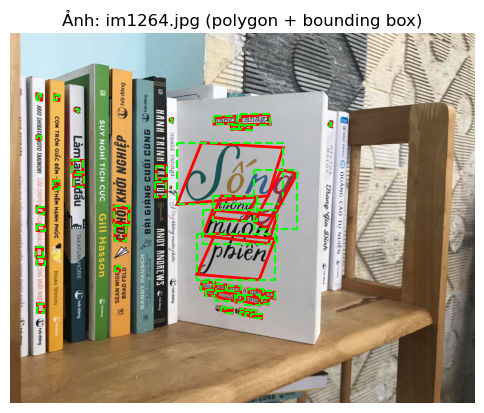

In [42]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import ast
from PIL import Image, ExifTags
import os

def open_image_correct_orientation(path):
    img = Image.open(path)
    try:
        for orientation in ExifTags.TAGS.keys():
            if ExifTags.TAGS[orientation] == 'Orientation':
                break
        exif = img._getexif()
        if exif is not None:
            orientation_value = exif.get(orientation, None)
            if orientation_value == 3:
                img = img.rotate(180, expand=True)
            elif orientation_value == 6:
                img = img.rotate(270, expand=True)
            elif orientation_value == 8:
                img = img.rotate(90, expand=True)
    except Exception as e:
        print(f"Lỗi khi xử lý Exif orientation: {e}")
    return img.convert("RGB")

def show_image_with_bbox(df, image_dir, img_name, index=None):
    """
    Hiển thị ảnh đúng chiều kèm polygon và khung chữ nhật bao quanh polygon.

    Args:
        df: DataFrame chứa "ImgName" và "BoundingBox"
        image_dir: thư mục chứa ảnh
        img_name: tên ảnh cần xem
        index: dòng cụ thể muốn kiểm tra bbox (optional)
    """
    img_path = os.path.join(image_dir, img_name)
    img = open_image_correct_orientation(img_path)

    fig, ax = plt.subplots(1)
    ax.imshow(img)

    bboxes = df[df["ImgName"] == img_name]
    if index is not None:
        bboxes = bboxes.iloc[[index]]

    for _, row in bboxes.iterrows():
        bbox = row["BoundingBox"]
        if isinstance(bbox, str):
            bbox = ast.literal_eval(bbox)

        polygon = [(bbox[i], bbox[i+1]) for i in range(0, len(bbox), 2)]

        # Vẽ polygon
        poly_patch = patches.Polygon(polygon, closed=True, fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(poly_patch)

        # Vẽ bounding box chữ nhật bao ngoài polygon
        x_coords = [p[0] for p in polygon]
        y_coords = [p[1] for p in polygon]
        x_min, x_max = min(x_coords), max(x_coords)
        y_min, y_max = min(y_coords), max(y_coords)
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                 linewidth=1.5, edgecolor='lime', facecolor='none', linestyle='--')
        ax.add_patch(rect)

        # Ghi tọa độ lên các điểm polygon
        # for (x, y) in polygon:
        #     ax.text(x, y, f'({int(x)},{int(y)})', color='yellow', fontsize=8)

    plt.title(f"Ảnh: {img_name} (polygon + bounding box)")
    plt.axis('off')
    plt.show()

show_image_with_bbox(test_df_processed, VIETNAMESE_DATASET['test_images'], 'im1264.jpg')

In [43]:
train_df_processed_cropped.head()

test_df_processed_cropped.head()

,ImgName,BoundingBox,GroundTruth,normalized,tokens,token_ids
36,im1203_2.jpg,"[138, 88, 204, 90, 208, 133, 138, 131]",MỘT,một,"[m, ộ, t]","[1, 27, 91, 34, 2]"
277,im1214_13.jpg,"[128, 243, 181, 243, 181, 256, 128, 256]",THƯỞNG,thưởng,"[t, h, ư, ở, n, g]","[1, 34, 22, 62, 94, 28, 21, 2]"
303,im1214_39.jpg,"[379, 224, 436, 224, 436, 258, 379, 257]",ĐÔ,đô,"[đ, ô]","[1, 58, 52, 2]"
23,im1202_18.jpg,"[199, 123, 260, 121, 260, 138, 199, 139]",KHÁNH,khánh,"[k, h, á, n, h]","[1, 25, 22, 42, 28, 22, 2]"
24,im1202_19.jpg,"[265, 121, 326, 120, 327, 136, 264, 137]",THÀNH,thành,"[t, h, à, n, h]","[1, 34, 22, 41, 28, 22, 2]"


## Lưu data

In [44]:
train_df_processed_cropped.to_csv(VIETNAMESE_DATASET['train_data'], index=False, encoding="utf-8")
print(f"Đã lưu dữ liệu train tại {VIETNAMESE_DATASET['train_data']}")

test_df_processed_cropped.to_csv(VIETNAMESE_DATASET['test_data'], index=False, encoding="utf-8")
print(f"Đã lưu dữ liệu train tại {VIETNAMESE_DATASET['test_data']}")

Đã lưu dữ liệu train tại ..\data\vietnamese\train_data.csv
Đã lưu dữ liệu train tại ..\data\vietnamese\test_data.csv
